In [1]:
from keras.callbacks import History
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.datasets import cifar10
from keras.engine import training
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Activation, Average
from keras.losses import categorical_crossentropy
from keras.models import Model, Input
from keras.optimizers import Adam
from keras.utils import to_categorical
from tensorflow.python.framework.ops import Tensor
from typing import Tuple, List
import glob
import numpy as np
import os

E:\Users\Arnab\Anaconda3\Lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from keras.models import load_model
import keras

In [3]:
from keras.models import Model
import tensorflow as tf
def top_3_accuracy(y_true, y_pred):
    return tf.keras.metrics.top_k_categorical_accuracy(y_true, y_pred, k = 3)
dependencies = {
    'top_3_accuracy' : top_3_accuracy
}

model1 = load_model('eins_corr.h5', custom_objects=dependencies)
model2 = load_model('eres.h5', custom_objects=dependencies)
model3 = load_model('eden.h5', custom_objects=dependencies)
model4 = load_model('eins_corr_no.h5', custom_objects=dependencies)
model5 = load_model('eres_no.h5', custom_objects=dependencies)
model6 = load_model('eden_no.h5', custom_objects=dependencies)

In [4]:
model1.name = '1'
model2.name = '2'
model3.name = '3'
model4.name = '4'
model5.name = '5'
model6.name = '6'

In [5]:
def ensembelModel(models, model_input):
    yModels = [model(model_input) for model in models]
    #outputs = [model.outputs[0] for model in models]
    #y = Average()(outputs)
    y = keras.layers.average(yModels)
    modelE = Model(inputs=model_input, outputs=y)
    return modelE

In [6]:
models = [model1, model2, model3, model4, model5, model6]
inputs = Input(shape=models[0].input_shape[1:])    
modelens = ensembelModel(models, inputs)
#modelens = ensembelModel([modelens1, modelens2, modelens3, modelens4, modelens5, modelens6], inputs)

In [7]:
modelens.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
1 (Model)                       (None, 122)          17647162    input_1[0][0]                    
__________________________________________________________________________________________________
2 (Model)                       (None, 122)          8980474     input_1[0][0]                    
__________________________________________________________________________________________________
3 (Model)                       (None, 122)          1369530     input_1[0][0]                    
__________________________________________________________________________________________________
4 (Model) 

In [8]:
#modelens.save('ensembled_f.h5')

In [9]:
#model = load_model('ensembled.h5')

In [10]:
from keras.preprocessing.image import ImageDataGenerator
import time
from keras.callbacks import TensorBoard
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import csv
from keras.utils.vis_utils import plot_model
from keras.callbacks import History
from matplotlib import pyplot as plt


In [11]:
i=32
train_data = ImageDataGenerator(rescale=1./255,validation_split = 0.2)#, rotation_range = 10, shear_range = .1 , zoom_range = .1, width_shift_range = .1, height_shift_range = .1)
test_data = ImageDataGenerator(rescale=1./255,validation_split = 0.2)

training = train_data.flow_from_directory('Ekush',target_size=(i,i), batch_size=64,class_mode='categorical', subset='training')
test = test_data.flow_from_directory('Ekush',target_size=(i,i), batch_size=64,class_mode='categorical', subset='validation')

Found 282835 images belonging to 122 classes.
Found 70646 images belonging to 122 classes.


In [12]:
from keras.callbacks import History, LearningRateScheduler
import math


modelens.trainable = False

epochs = 50
def step_decay(epochs):
    initial_lrate = 0.0005
    drop = 0.5
    epochs_drop = 5.0
    lrate = initial_lrate * math.pow(drop,  
           math.floor((1+epochs)/epochs_drop))
    return lrate

lrate=LearningRateScheduler(step_decay)

opt= Adam()
modelens.compile(optimizer=opt, loss = "categorical_crossentropy", metrics= ["accuracy", top_3_accuracy])
#modelens.evaluate_generator(test)
#modelens.fit_generator(training, epochs=1, validation_data=test)

In [13]:
modelens.evaluate_generator(test)

[0.11451393861032622, 0.9732327378559223, 0.9955694589927243]

In [14]:
start = time.time()
test_data = ImageDataGenerator(rescale=1./255,validation_split = 0.2)
testp = test_data.flow_from_directory('Ekush',target_size=(i,i), batch_size=64,class_mode='categorical', subset='validation',shuffle=False)        
start1 = time.time()
t_pred = modelens.predict_generator(testp)
end = time.time()
pred = np.argmax(t_pred, axis=1)
print(pred)
print('Confusion Matrix')
conf = confusion_matrix(testp.classes, pred)
print(conf)
print('Classification Report')
target_names = ['0', '1', '2', '3', '4', '5','6', '7', '8', '9']
for k in range(10,122):
    k1=k
    target_names.append(str(k1))
f1 = classification_report(testp.classes, pred, target_names=target_names)
print(f1)
print("\nDirectory and predict: ",end-start)
print("Predict: ",end-start1)

Found 70646 images belonging to 122 classes.
[  0   0   0 ... 121 121 121]
Confusion Matrix
[[501   4   0 ...   0   0   0]
 [  3 528   0 ...   0   0   0]
 [  0   0 531 ...   0   0   0]
 ...
 [  0   0   0 ... 385   0   0]
 [  0   0   0 ...   0 576   0]
 [  0   0   0 ...   1   1 585]]
Classification Report
             precision    recall  f1-score   support

          0       0.99      0.99      0.99       507
          1       0.99      0.99      0.99       531
          2       0.99      0.97      0.98       546
          3       0.99      0.97      0.98       599
          4       0.99      1.00      1.00       599
          5       0.99      0.99      0.99       599
          6       0.99      0.98      0.98       599
          7       0.96      0.96      0.96       596
          8       0.97      0.97      0.97       600
          9       0.98      0.99      0.98       601
         10       0.95      0.97      0.96       554
         11       0.99      0.99      0.99       602
    

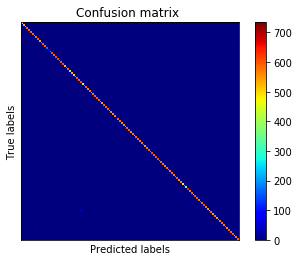

In [15]:
plt.imshow(conf, cmap=plt.cm.jet)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.xticks([], [])
plt.yticks([], [])
plt.title('Confusion matrix ')
plt.colorbar()
plt.show()
#print(model.summary())

In [16]:
cnt = 1
for i in conf:
    for j in range(0, len(i)):
        if((cnt != (j+1)) & (i[j] > 14)):
            print(str(cnt) + "   " + str(j+1) + " = " +str(i[j]))
    cnt = cnt + 1

16   89 = 16
50   22 = 21
52   58 = 20
53   20 = 27
58   52 = 23
59   55 = 22
62   50 = 21
64   69 = 19
70   63 = 15
87   11 = 18
89   16 = 17
89   97 = 16
93   54 = 15
97   16 = 16
97   89 = 29
104   95 = 16
106   34 = 72
106   120 = 22
114   9 = 19
120   109 = 15


In [17]:
cnt = 1
for i in conf:
    print(cnt)
    print(i)
    cnt = cnt +1

1
[501   4   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   2   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
2
[  3 528   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
3
[ 

   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
78
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   2   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   2   0 582   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
79
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   3   0   0   0   0   0   0   1   0   1   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0 590   0   0   0   0   0   0   0   0   0   0   1
   0   0   0   0   0   0   0   0   0   0   1   0   0   0   0   0   0   0
  

In [18]:
conf[0][0]

501

In [19]:
truth = []

for i in range(208):
    x, y = next(testp)
    #predd.append(modelens.predict_generator(x, steps=64))
    truth.append(y) 

#predd = np.concatenate(predd)
truth = np.concatenate(truth)

In [20]:
truth.shape

(13312, 122)

In [21]:
y.shape[0]

64

In [22]:
pred_t = pred
pred_t.shape

(70646,)

In [23]:
import sys
import numpy
pred1 = np.expand_dims(pred_t, axis=1)
pred1.shape

(70646, 1)

In [24]:
import pandas as pd
c1 = np.round(t_pred)
files = testp.filenames

results = pd.DataFrame({'files':files, 'Pr':pred_t[:,0], 'class':c1[:,0]})
results.head(20)

IndexError: too many indices for array

In [ ]:
print(pred.shape)
pred1 = np.expand_dims(pred, axis=1) # make same shape as y_test
print(pred1)
b = np.zeros((pred1.size, pred1.max()+1))
b[np.arange(pred1.size),pred1] = 0
print(b)
print(truth)
error = np.sum(np.not_equal(b, truth)) / truth.shape[0] 

In [ ]:
error

In [ ]:
#import tensorflow as tf
#tf.enable_eager_execution()
cce = keras.losses.CategoricalCrossentropy()
cce(truth, b).numpy()

In [ ]:
import cv2

In [ ]:
img = cv2.imread('01_0001_0_15_0916_0438_2.png')

In [ ]:
img = cv2.resize(img, (32,32))

In [ ]:
img = np.reshape(img, [1, 32, 32, 3])

In [ ]:
classes = modelens.predict(img)
print(np.argmax(classes, axis=1))

In [ ]:
num = []
for k in range(1, 122):
    num.append(str(k))

In [ ]:
num.sort()

In [ ]:
num

In [ ]:
ints = np.arange(1,122)
for inx in range(0,121):
    print(str(ints[inx]) + " = " + num[inx])

E:\Users\Arnab\Anaconda3\envs\tensorflow\lib\site-packages\matplotlib\text.py:1191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


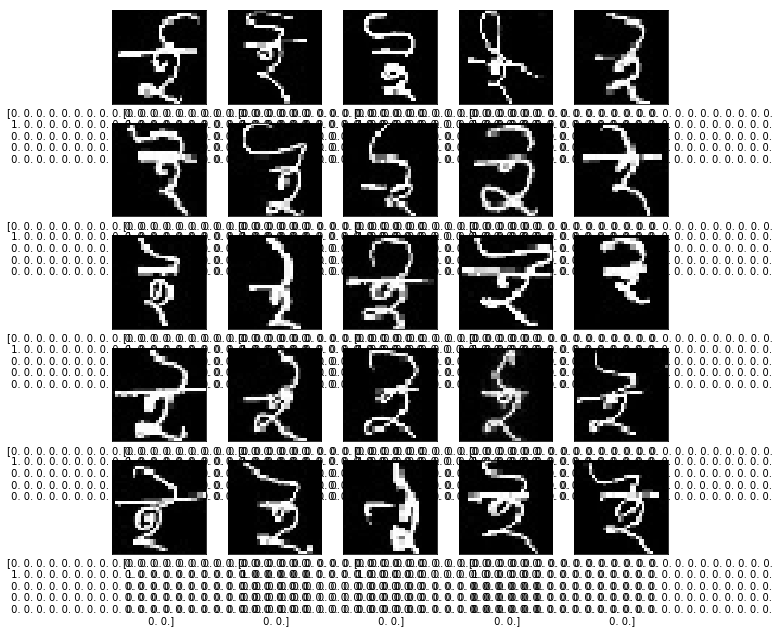

In [28]:
img, label = next(testp)
plt.figure(figsize=(10,10))
for m in range(25):
    plt.subplot(5, 5, m+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img[m], cmap=plt.cm.binary)
    plt.xlabel(label[m])
    

In [29]:
conf

array([[501,   4,   0, ...,   0,   0,   0],
       [  3, 528,   0, ...,   0,   0,   0],
       [  0,   0, 531, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ..., 385,   0,   0],
       [  0,   0,   0, ...,   0, 576,   0],
       [  0,   0,   0, ...,   1,   1, 585]], dtype=int64)

In [30]:
df = pd.DataFrame(conf)

In [31]:
df

,0,1,2,3,4,5,6,7,8,9,...,112,113,114,115,116,117,118,119,120,121
0,501,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3,528,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,531,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,583,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,598,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
5,0,0,0,0,0,591,0,0,0,1,...,0,0,0,3,0,0,0,0,0,0
6,0,0,0,0,0,0,586,0,0,0,...,0,1,1,0,0,2,0,0,0,0
7,0,0,0,0,0,0,0,572,0,0,...,0,0,1,1,0,1,0,0,0,4
8,0,0,0,0,0,0,1,0,580,0,...,0,14,0,0,3,0,1,0,0,0
9,0,0,0,0,0,0,0,0,0,593,...,0,0,0,0,1,0,0,0,0,0


In [ ]:
df.to_csv('ekush_co')